In [2]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm
from scipy import signal
from scipy import fftpack
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def get_fft(filename):
    fp = open(filename, "rb")
    adc_data = fp.read()
    fp.close()

    adc_data_i = []
    adc_data_q = []
    time_iq = []
    for i in range(0, int(len(adc_data)/4)):
        temp = (int(adc_data[4*i+0]) * 2**0) + (int(adc_data[4*i+1]) * 2**8)
        if not temp < 2**15:
            temp = temp - 2**16
        adc_data_i.append( temp )
                    
        temp = (int(adc_data[4*i+2]) * 2**0) + (int(adc_data[4*i+3]) * 2**8)
        if not temp < 2**15:
            temp = temp - 2**16
        adc_data_q.append( temp )
        time_iq.append(0.05*i)

    #パケットヘッダのデータ量1280までを無視する
    fft = []
    for i in range(1280,int(len(adc_data_i))):
        temp = complex(adc_data_i[i],adc_data_q[i])
        fft.append(temp)
    #print("jkjl",len(fft))

    rate = 20000000 #設定>サンプリングレート>デジタルデータ(default 40000000)の値の半分 
    N =len(fft)     #データ長
    freq = np.fft.fftfreq(len(fft), 1.0 / rate)  #周波数軸 中心は0
    F=np.fft.fft(fft)/(N/2)
    F = np.abs(F)

    return F, freq

def conv(F_list):
    n = len(F_list[0])
    res = [1 for i in range(n)]
    #print(len(F_list),len(F_list[0]))
    for i in range(len(F_list[0])):
        for j in range(len(F_list)):
            res[i] += F_list[j][i]
    return res

def raws_average(F_list):
    n = len(F_list[0])
    res = [0 for i in range(n)]
    for i in range(len(F_list[0])):
        for j in range(len(F_list)):
            res[i] += F_list[j][i]
    return res

def discard_data(F):
    if len(F) != 53360:
        return True
    else:
        return False

def amp_filter(F,THRESHHOLD):
    for i in range(len(F)):
        if F[i] >= THRESHHOLD:
            F[i] = THRESHHOLD
    return F

def make_figs(F,freq,fname):
    rate = 20000000 
    fig_adc = plt.figure(dpi=1000,figsize=(30,4))       #詳しく見たいなら dpi=1000,figsize=(30,4) などを引数にする
    ax_adc = fig_adc.add_subplot(111)
    ax_adc.plot(freq/1000000,np.abs(F)) #MHz表記のため10e6で割る
    plt.title(fname,fontsize=28)
    plt.tick_params(labelsize=28)

    #表示が切れたり，より細かく見たい時に以下を調整
    plt.xticks(np.arange(-rate/2, rate/2+1, 1000000)/1000000)
    plt.xlim(0,rate/2/1000000)
    #plt.yticks(np.arange(0, 50, 5))
    plt.ylim(0,50)

    plt.xlabel("Freq[MHz]",fontsize=28)
    plt.ylabel("Amp",fontsize=28,rotation=0)
    plt.grid()
    #fig_adc.savefig(fname+ "fft.png",bbox_inches='tight',pad_inches=0.1)

def find_peak(stream,n1,n2,th):
    for i in range(n1,len(stream)-n2):
        ave1 = sum(stream[i-n1:i])/n1
        ave2 = sum(stream[i+1:i+n2+1])/n2
        #print(ave1,ave2,ave1*th,ave1*th < ave2)
        if ave1*th < ave2:
            return 1
    return 0

def find_peak2(stream,n1,n2,th):
    print(stream)
    for i in range(n1,len(stream)-n2):
        ave1 = sum(stream[i-n1:i])/n1
        ave2 = sum(stream[i+1:i+n2+1])/n2
        #print(ave1,ave2,ave1*th,ave1*th < ave2)
        if ave1*th < ave2:
            return 1
    return 0

def get_timestamp(file):
    f = open(file, 'r')
    data = f.read()
    f.close()
    return int(data)

def get_peak_res(exp,place,stream):
    THRESHHOLD = 1.1
    n1 = 10
    n2 = 3
    tmp = conv(stream)
    for i in range(18654,18656):
        tmp[i] *= 0.5
    

    if place == "corridor":
        id1 = tmp[15950:16050]
        id2 = tmp[16400:16600]
        id1_ = find_peak(id1,n1,n2,THRESHHOLD)
        id2_ = find_peak(id2,n1,n2,THRESHHOLD)
        return [id1_,id2_,0,0,0,0,0,0]
    elif place == "kitchen":
        id3 = tmp[17000:17200]
        id5 = tmp[18050:18250]
        id3_ = find_peak(id3,n1,n2,THRESHHOLD)
        id5_ = find_peak(id5,n1,n2,THRESHHOLD)
        return [0,0,id3_,id5_,0,0,0,0]
    elif place == "living":
        id6 = tmp[18600:18800]
        id7 = tmp[19100:19300]
        id6_ = find_peak(id6,n1,n2,THRESHHOLD)
        id7_ = find_peak(id7,n1,n2,THRESHHOLD)
        return [0,0,0,0,id6_,id7_,0,0]
    elif place == "bedroom":
        id8 = tmp[19800:20000]
        id9 = tmp[20200:20400]
        id8_ = find_peak(id8,n1,n2,THRESHHOLD)
        id9_ = find_peak(id9,n1,n2,THRESHHOLD)
        return [0,0,0,0,0,0,id8_,id9_]

def uniform(place1,place2):
    common_start = max(min(place1.keys()), min(place2.keys()))
    common_end = min(max(place1.keys()), max(place2.keys()))
    keys_to_remove = [key for key in place1 if key < common_start or key > common_end]
    for key in keys_to_remove:
        place1.pop(key)

    keys_to_remove = [key for key in place2 if key < common_start or key > common_end]
    for key in keys_to_remove:
        place2.pop(key)
    common_start = max(min(place1.keys()), min(place2.keys()))
    common_end = min(max(place1.keys()), max(place2.keys()))
    keys_to_remove = [key for key in place1 if key < common_start or key > common_end]
    for key in keys_to_remove:
        place1.pop(key)

    keys_to_remove = [key for key in place2 if key < common_start or key > common_end]
    for key in keys_to_remove:
        place2.pop(key)
    return place1,place2

def get_8packets(data):
    for timestamp in data:
        while len(data[timestamp]) < 8:
            data[timestamp].append(data[timestamp][random.randint(0,len(data[timestamp]))-1])
    return data

def get_tag_vec(senario,stream1,stream2):
    THRESHHOLD = 1.3
    n1 = 10
    n2 = 1
    
    for i in range(18654,18656):
        stream1[i] *= 0.5
    for i in range(18654,18656):
        stream2[i] *= 0.5

    if senario == "second":
        id1 = stream1[15600:16200]
        id2 = stream1[16400:16600]
        id1_ = find_peak(id1,n1,n2,1.5)
        id2_ = find_peak(id2,10,1,1.5)
        id8 = stream2[19800:20000]
        id9 = stream2[20200:20400]
        id8_ = find_peak(id8,n1,n2,1.4)
        id9_ = find_peak(id9,n1,n2,1.4)
        return [id1_,id2_,0,0,0,0,id8_,id9_]
    elif senario == "first":
        #ID3 17000,17200
        #ID4 17500,17700
        #ID5 18050,18250
        #ID6 18600,18800 #18650,18670 noise
        #ID7 19100,19300
        id3 = stream1[17000:17200]
        id5 = stream1[18050:18250]
        id3_ = find_peak(id3,n1,n2,2.5)
        id5_ = find_peak(id5,10,1,2.5)
        #id6 = stream2[18600:18700] + stream2[18720:18800]
        id6 = stream2[18600:18800]
        id7 = stream2[19100:19300]
        id6_ = find_peak(id6,n1,n2,2.5)
        id7_ = find_peak(id7,n1,n2,2.5)
        return [0,0,id3_,id5_,id6_,id7_,0,0]
    elif senario == "first2":
        #ID3 17000,17200
        #ID4 17500,17700
        #ID5 18050,18250
        #ID6 18600,18800 #18650,18670 noise
        #ID7 19100,19300
        id3 = stream1[17000:17200]
        id5 = stream1[18050:18250]
        id3_ = find_peak(id3,n1,n2,2.5)
        id5_ = find_peak(id5,10,1,2.5)
        #id6 = stream2[18600:18700]
        #id6 = stream2[18600:18700] + stream2[18720:18800]
        id6 = stream2[18600:18800]
        id7 = stream2[19100:19300]
        id6_ = find_peak(id6,n1,n2,2.5)
        id7_ = find_peak(id7,n1,n2,2.5)
        return [0,0,id3_,id5_,id6_,id7_,0,0]

def get_full_list(time_data1):
    for time in time_data1:
        for i in range(len(time_data1[time])):
            c = []
            if len(time_data1[time][i]) != 53360:
                c.append(i)
        if len(c) != 0:
            tmp = []
            print(c,time)
            for j in range(len(time_data1[time])):
                if j not in c:
                    tmp.append(time_data1[time][i])
            time_data1[time] = tmp
    for time in time_data1:
        for i in time_data1[time]:
            if len(i) != 53360:
                print(len(i))
    return time_data1

def get_annotation(senario,subject,session):
    # session = "session1"
    # subject = "subject1"
    # senario = "second"

    file = "./" + subject + "/" + senario + "/annotation/" + session + ".csv"
    df = pd.read_csv(file,header=None, names=["timestamp","activity"])
    start = df.iloc[2][1]
    end = df.iloc[-1][1]

    annot = {}
    c = 0
    for i in range(1,len(df)):
        if df.iloc[i-1][-1] + 1 != df.iloc[i][-1]:
            activity = df.iloc[i-1][0]
            if activity == "other":
                activity = activity + str(c)
                c += 1
            start = df.iloc[i-1][-1]
            end = df.iloc[i][-1]
            annot[activity] = {
                "start" : start,
                "end" : end
        }
    return annot

def get_activity(annot,time):
    for act in annot:
        start = annot[act]["start"]
        end = annot[act]["end"]
        if start <= time <= end:
            return act
    return False

In [ ]:

#exps = ["./test_switch/"]
window = 8
DIR = "./"
subjects = ["subject3"]#,"subject3"]
senarios = ["first"]#"first2"]
sessions = ["session3","session4"]#,"session2"]
places = ["living","kitchen"]
for subject in subjects:
    for senario in senarios:
        for session in sessions:
            data1 = {}
            data2 = {}
            samples1 = os.listdir(DIR + subject + "/" + senario + "/" + session +"/" + "kitchen" + "/")
            samples2 = os.listdir(DIR + subject + "/" + senario + "/" + session +"/" + "living" + "/")

            for data in samples1:
                raws = []
                #print(DIR + subject + "/" + senario + "/" + session +"/" + "kitchen" + "/" + data + "/")
                raw0_fname = glob.glob(DIR + subject + "/" + senario + "/" + session +"/" + "kitchen" + "/" + data + "/*RAW0.dat")[0]
                raw1_fname = glob.glob(DIR + subject + "/" + senario + "/" + session +"/" + "kitchen" + "/" + data + "/*RAW1.dat")[0]

                try:
                    raw0,freq = get_fft(raw0_fname)
                    raws.append(raw0)
                except:
                    pass

                try:
                    raw1,freq = get_fft(raw1_fname)
                    raws.append(raw1)
                except:
                    pass

                try:
                    timestamp = get_timestamp(glob.glob(DIR + subject + "/" + senario + "/" + session +"/" + "kitchen" + "/" + data + "/log_timestamp.py.log")[0])
                    if len(raws) != 0:
                        data1[timestamp] = raws
                    else:
                        data1[timestamp] = []
                except:
                    pass

            for data in samples2:
                raws = []
                raw0_fname = glob.glob(DIR + subject + "/" + senario + "/" + session +"/" + "living" + "/" + data + "/*RAW0.dat")[0]
                raw1_fname = glob.glob(DIR + subject + "/" + senario + "/" + session +"/" + "living" + "/" + data + "/*RAW1.dat")[0]

                try:
                    raw0,freq = get_fft(raw0_fname)
                    raws.append(raw0)
                except:
                    pass

                try:
                    raw1,freq = get_fft(raw1_fname)
                    raws.append(raw1)
                except:
                    pass

                try:
                    timestamp = get_timestamp(glob.glob(DIR + subject + "/" + senario + "/" + session +"/" + "living" + "/" + data + "/log_timestamp.py.log")[0])
                    if len(raws) != 0:
                        data2[timestamp] = raws
                    else:
                        data2[timestamp] = []
                except:
                    pass
            print(sorted(list(data1.keys())))
            print(sorted(list(data2.keys())))

            place1,place2 = uniform(data1,data2)
            keys = sorted(list(place1.keys()))
            annot = get_annotation(senario,subject,session)
            result = []
            result2 = []
            for time in keys:
                try:
                    act = get_activity(annot,time)
                    if not act:
                        pass
                    else:
                        if act[0:5] == "other":
                            act = "other"
                        result.append([time] + get_tag_vec(senario,conv(place1[time]),conv(place2[time])) + [act])
                        result2.append(get_tag_vec(senario,conv(place1[time]),conv(place2[time])))
                        #print(get_tag_vec(senario,conv(time_data1[time]),conv(time_data2[time])))
                except:
                    print("aaaa")
                    pass
            df = pd.DataFrame(result, columns=["time","ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9","activity"])
            df.to_csv("./" + subject + "/" + senario + "/" + session + "/annotated_data.csv", index=False)
            #print(result)
            plt.figure(figsize=(25,50))

            plt.imshow(result2, cmap='gray')  # カラーマップは 'gray' としていますが、必要に応じて変更できます
            plt.show()

In [ ]:
"""
欠損値埋め
"""
sessions = ["session1","session2","session3"]
windows = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
subjects = ["subject1","subject2","subject3"]
senarios = ["first","first2","second"]

for subject in subjects:
    for senario in senarios:
        for session in sessions:
            df = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/annotated_data.csv")
            # タイムスタンプの差分を計算
            diff = df['time'].diff()

            # 1より大きい差分を持つインデックスを取得
            missing_indices = df.index[diff > 1]

            for idx in missing_indices:
                # 欠けているタイムスタンプを出力
                print(f"Missing timestamp: {df.at[idx-1, 'time'] + 1}")

                # 欠けているデータを前の行のデータで埋める
                missing_row = df.iloc[idx-1].copy()
                missing_row['time'] += 1
                df = pd.concat([df.iloc[:idx], pd.DataFrame([missing_row], columns=df.columns), df.iloc[idx:]]).reset_index(drop=True)
            df.to_csv("./" + subject + "/" + senario + "/" + session + "/annotated_data2.csv", index=False)

            # 結果を出力（オプション）
            #print(df)

In [ ]:
"""
leave one session out
"""
sessions = ["session1","session2","session3"]
windows = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
subjects = ["subject1","subject2","subject3"]
senarios = ["first","first2","second"]

for subject in subjects:
    win_acc_f = []
    res_label = ["window","accuracy","f_value","precision","recall"]
    for window in windows:
        print("---",window,"---")
        ses_acc = []
        ses_f = []
        ses_recall = []
        ses_pre = []
        for session in sessions:
            ses_train_y = []
            ses_test_y = []
            ses_train_X = []
            ses_test_X = []
            train = []
            test = []
            for target in sessions:
                if session == target:
                    test.append(target)
                    #session = "session2"

                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                    #df = pd.read_csv("./" + subject + "/" + senario + "/" + session + "/annotated_data.csv")
                    for i in range(0, len(df), window):
                        data_seg = df.iloc[i:i+window]
                        acts = data_seg['activity'].tolist()
                        if len(set(acts)) == 1 and len(acts) == window:
                            selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                            tmp_data = [item for col in selected_columns for item in data_seg[col]]
                            ses_test_X.append(tmp_data)
                            ses_test_y.append(acts[0])
                else:
                    #session = "session2"
                    train.append(target)
                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                    #df = pd.read_csv("./" + subject + "/" + senario + "/" + session + "/annotated_data.csv")
                    for i in range(0, len(df), window):
                        data_seg = df.iloc[i:i+window]
                        acts = data_seg['activity'].tolist()
                        if len(set(acts)) == 1 and len(acts) == window:
                            selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                            tmp_data = [item for col in selected_columns for item in data_seg[col]]
                            ses_train_X.append(tmp_data)
                            ses_train_y.append(acts[0])
            clf_rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=50)
            clf_rf.fit(ses_train_X, ses_train_y)
            clf_rf_pred = clf_rf.predict(ses_test_X)
            rf_acc = accuracy_score(ses_test_y, clf_rf_pred)
            rf_fscore = f1_score(ses_test_y, clf_rf_pred,average="weighted")
            rf_recall = recall_score(ses_test_y, clf_rf_pred,average="weighted")
            rf_pre = precision_score(ses_test_y, clf_rf_pred,average="weighted")
            print("test : ",test," train : ",train)
            print("rf_acc : ",rf_acc,"rf_fscore : ",rf_fscore)
            ses_acc.append(rf_acc)
            ses_f.append(rf_fscore)
            ses_pre.append(rf_pre)
            ses_recall.append(rf_recall)
        win_acc_f.append([window] + [round(sum(ses_acc)/len(ses_acc),3)] +[round(sum(ses_f)/len(ses_f),3)] + [round(sum(ses_pre)/len(ses_pre),3)] +[round(sum(ses_recall)/len(ses_recall),3)])
        #win_f.append([window] + [ses_f] + [round(ses_f/len(ses_f),3)])
    print(win_acc_f)
    df = pd.DataFrame(win_acc_f, columns=res_label)
    df.to_csv("./" + subject + "/" + "result.csv", index=res_label)

In [ ]:
"""
leave one person out
"""

subjects = ["subject1","subject2","subject3"]
win_acc_f = []
for window in windows:
    #res_label = ["window","sub1_acc","sub2_acc","sub3_acc","subave","sub1_f","sub2_f","sub3_f","sesave"]
    res_label = ["window","accuracy","f_value","precision","recall"]
    sub_test_X = []
    sub_test_y = []
    sub_train_X = []
    sub_train_y = []
    train = []
    test = []
    sub_acc = []
    sub_f = []
    sub_recall = []
    sub_pre = []
    for subject in subjects:
        for target in subjects:
            if target == subject:
                test.append(target)
                for session in sessions:
                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                for i in range(0, len(df), window):
                    data_seg = df.iloc[i:i+window]
                    acts = data_seg['activity'].tolist()
                    if len(set(acts)) == 1 and len(acts) == window:
                        selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                        tmp_data = [item for col in selected_columns for item in data_seg[col]]
                        sub_test_X.append(tmp_data)
                        sub_test_y.append(acts[0])        
            else:
                train.append(target)
                for session in sessions:
                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                for i in range(0, len(df), window):
                    data_seg = df.iloc[i:i+window]
                    acts = data_seg['activity'].tolist()
                    if len(set(acts)) == 1 and len(acts) == window:
                        selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                        tmp_data = [item for col in selected_columns for item in data_seg[col]]
                        sub_train_X.append(tmp_data)
                        sub_train_y.append(acts[0])       
        clf_rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=50)
        clf_rf.fit(sub_train_X, sub_train_y)
        clf_rf_pred = clf_rf.predict(sub_test_X)
        rf_acc = accuracy_score(sub_test_y, clf_rf_pred)
        rf_fscore = f1_score(sub_test_y, clf_rf_pred,average="weighted")
        rf_recall = recall_score(sub_test_y, clf_rf_pred,average="weighted")
        rf_pre = precision_score(sub_test_y, clf_rf_pred,average="weighted")
        
        print("test : ",test," train : ",train)
        print("rf_acc : ",rf_acc,"rf_fscore : ",rf_fscore)
        sub_acc.append(rf_acc)
        sub_f.append(rf_fscore)
        sub_recall.append(rf_recall)
        sub_pre.append(rf_pre)
    win_acc_f.append([window] + [round(sum(sub_acc)/len(sub_acc),3)] + [round(sum(sub_f)/len(sub_f),3)] + [round(sum(sub_pre)/len(sub_pre),3)] + [round(sum(sub_recall)/len(sub_recall),3)])
    #win_f.append([window] + [ses_f] + [round(ses_f/len(ses_f),3)])
print(win_acc_f)
res_df = pd.DataFrame(win_acc_f, columns=res_label)
print(res_df)
res_df.to_csv("./" + "result.csv", columns=res_label)

In [ ]:
senarios = ["first","first2","second"]
sessions = ["session1","session2","session3"]
attenuation_rates = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
subjects = ["subject1","subject2","subject3"]

for attenuation_rate in attenuation_rates:
    for subject in subjects:
        for senario in senarios:
            for session in sessions:

                # ファイル名と減衰率を設定
                filename = DIR + subject + "/" + senario + "/" + session + "/" + "annotated_data.csv"

                # CSVファイルを読み込み
                df = pd.read_csv(filename)

                for col in df:
                    tmp = []
                    if col != "activity":
                        for i in range(1,len(df[col])+1):
                            if df[col][i-1] == 1:
                                tmp.append(1)
                            else:
                                if len(tmp) == 0:
                                    tmp.append(0)
                                else:
                                    tmp.append(round(tmp[-1]*attenuation_rate,5))
                        df[col] = tmp
                #print(df)
                df.to_csv(DIR + subject + "/" + senario + "/" + session + "/" + str(attenuation_rate) +"_annotated_data.csv",index=False)

In [ ]:
filename = DIR + "subject3" + "/result.csv"
df = pd.read_csv(filename)

df2 = df.iloc[5:11,[1,2,3,4,5]]
df2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# データ
labels = [str(i) for i in range(1,11)]
values1 = [0.944,0.938,0.948,0.944]
values2 = [0.946,0.938,0.953,0.946]
values3 = [0.942,0.934,0.952,0.942]
values4 = [0.963,0.957,0.967,0.963]
values5 = [0.968,0.964,0.971,0.968]
values6 = [0.971,0.967,0.975,0.971]

# バーの幅と位置の設定
bar_width = 0.35
index = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# バーグラフの作成
plt.bar(index, values1, bar_width, label='Value1', color='b', align='center')
plt.bar(index + bar_width, values2, bar_width, label='Value2', color='r', align='center')

# x軸のラベルの設定
plt.xlabel('Label')
plt.ylabel('Value')
plt.title('Multiple bars in one item')
plt.xticks(index + bar_width / 2, labels)  # ラベルの位置を中央に調整
plt.legend()

# グラフの表示
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# データフレームの作成
data = {
    'window': [6, 7, 8, 9, 10],
    'accuracy': [0.944, 0.946, 0.942, 0.963, 0.968],
    'f_value': [0.938, 0.938, 0.934, 0.957, 0.964],
    'precision': [0.948, 0.953, 0.952, 0.967, 0.971],
    'recall': [0.944, 0.946, 0.942, 0.963, 0.968]
}
df = pd.DataFrame(data)

# バーグラフの設定
bar_width = 0.2
index = np.arange(len(df['window']))

# 各メトリックに対するバーグラフの描画
plt.bar(index, df['accuracy'], bar_width, label='accuracy', color='b', align='center')
plt.bar(index + bar_width, df['f_value'], bar_width, label='f_value', color='r', align='center')
plt.bar(index + 2*bar_width, df['precision'], bar_width, label='precision', color='g', align='center')
plt.bar(index + 3*bar_width, df['recall'], bar_width, label='recall', color='y', align='center')

# x軸の設定
plt.xlabel('Window')
plt.ylabel('Value')
plt.title('Metrics for different windows')
plt.xticks(index + 1.5*bar_width, df['window'])  # ラベルの位置を中央に調整
plt.legend()

# グラフの表示
plt.tight_layout()
plt.show()


--- 7 ---


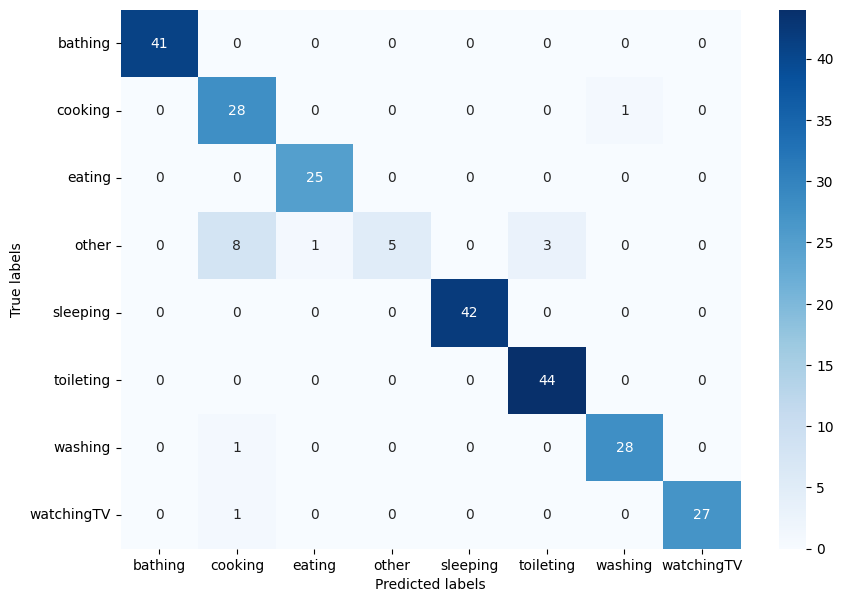

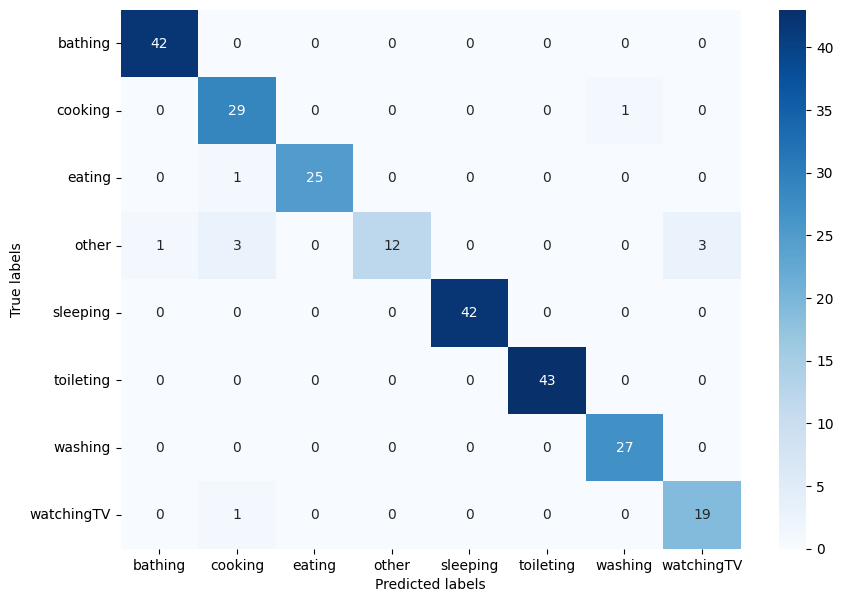

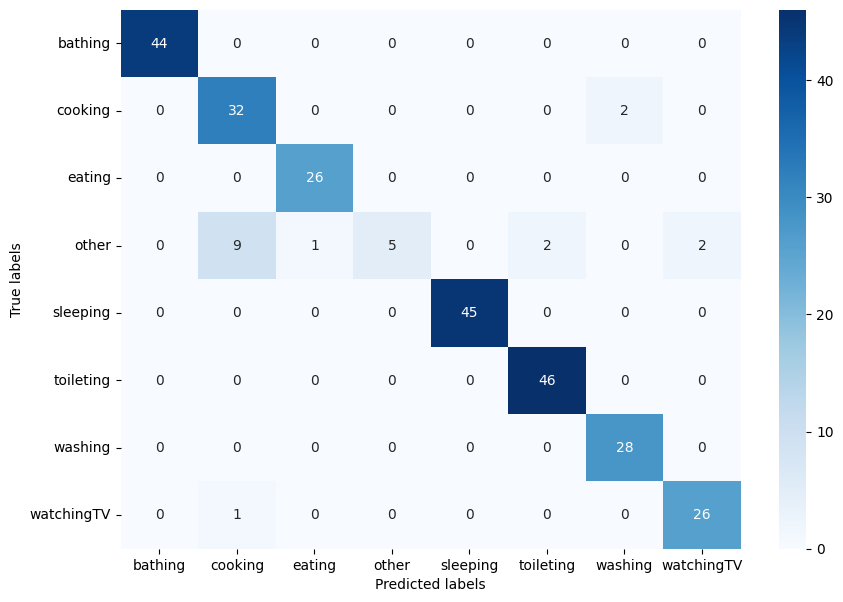

--- 7 ---


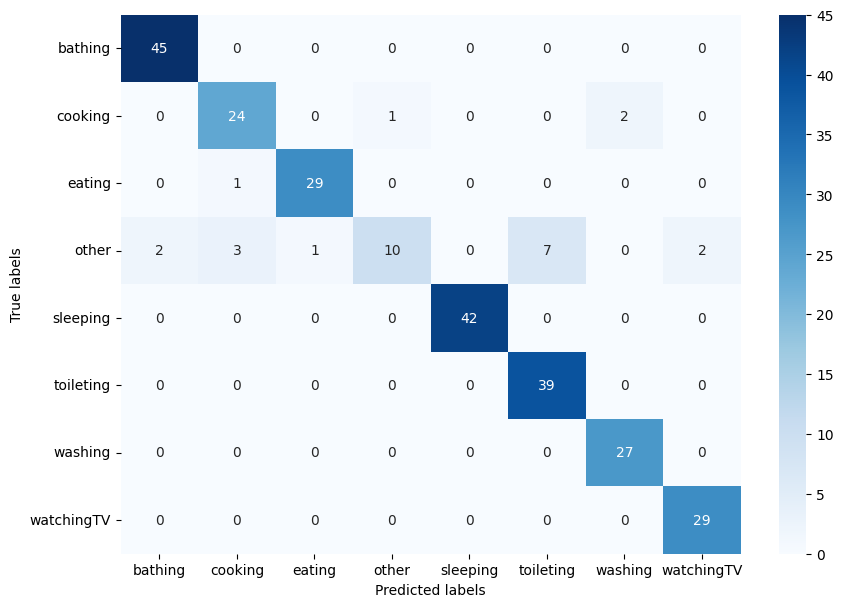

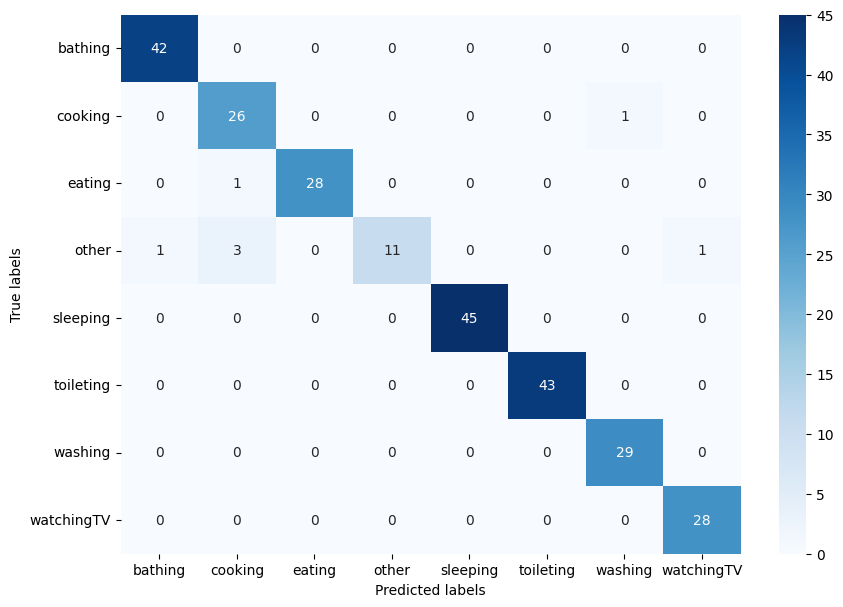

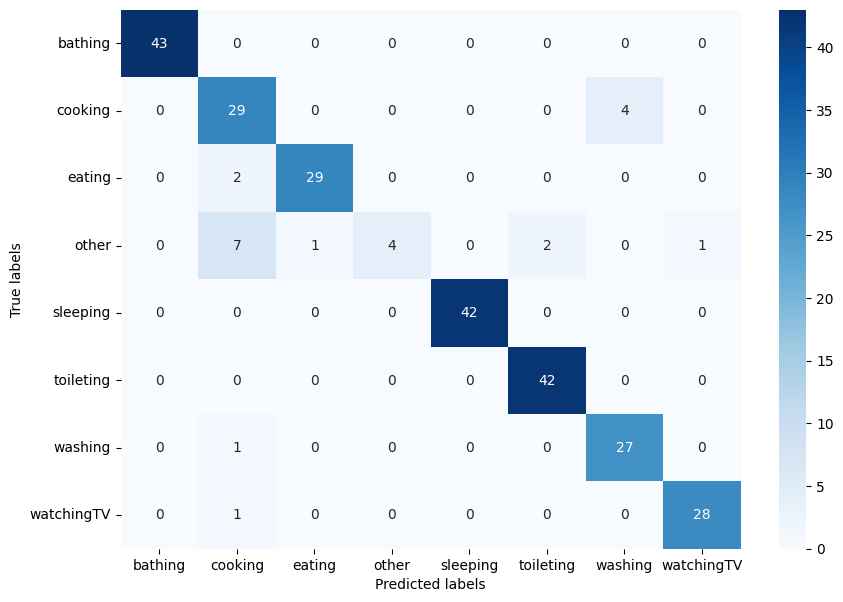

--- 7 ---


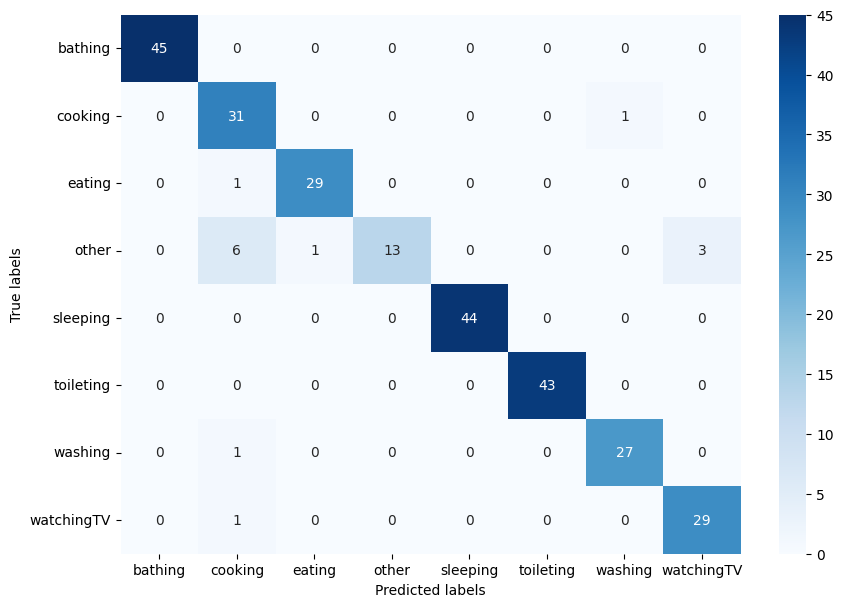

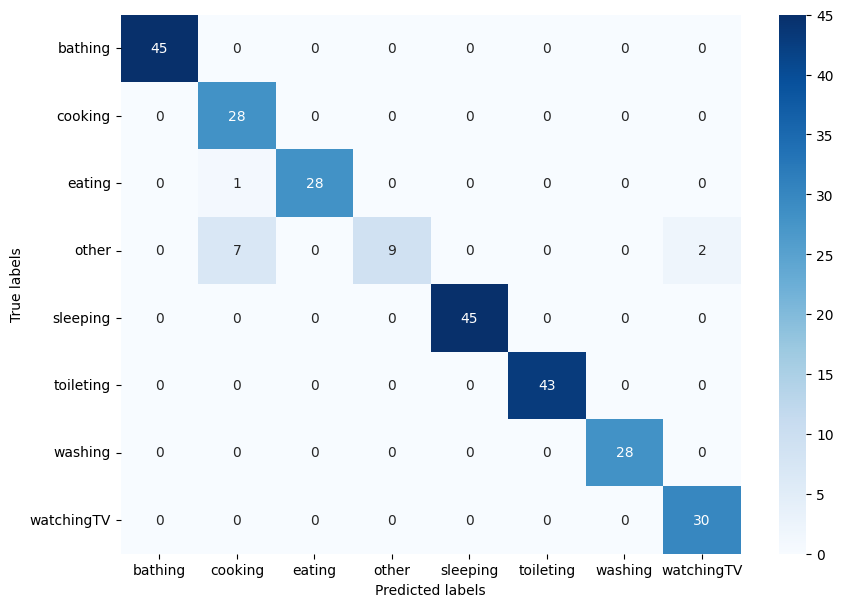

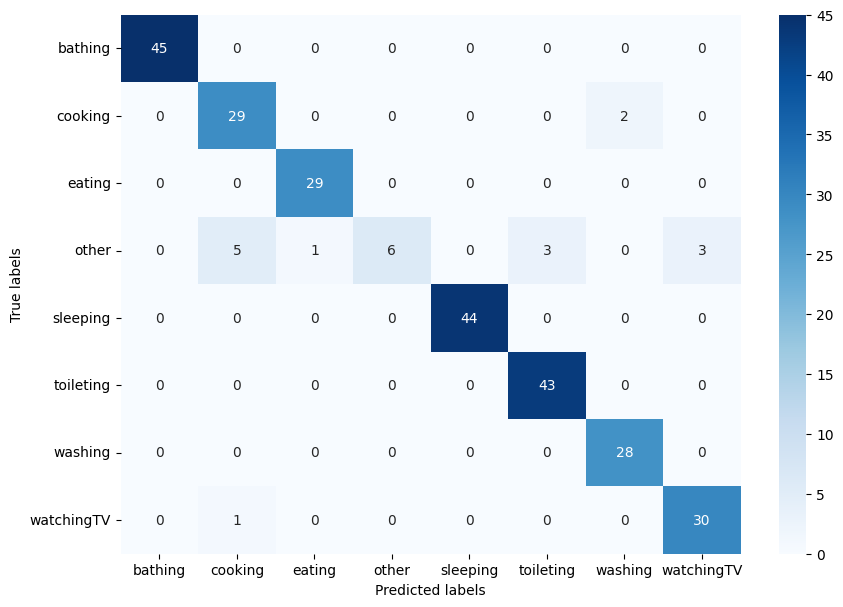

In [4]:
"""
leave one session out CM
"""
sessions = ["session1","session2","session3"]
windows = [7]
subjects = ["subject1","subject2","subject3"]
senarios = ["first","first2","second"]

for subject in subjects:
    win_acc_f = []
    res_label = ["window","accuracy","f_value","precision","recall"]
    for window in windows:
        print("---",window,"---")
        ses_acc = []
        ses_f = []
        ses_recall = []
        ses_pre = []
        for session in sessions:
            ses_train_y = []
            ses_test_y = []
            ses_train_X = []
            ses_test_X = []
            train = []
            test = []
            for target in sessions:
                if session == target:
                    test.append(target)
                    #session = "session2"

                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                    #df = pd.read_csv("./" + subject + "/" + senario + "/" + session + "/annotated_data.csv")
                    for i in range(0, len(df), window):
                        data_seg = df.iloc[i:i+window]
                        acts = data_seg['activity'].tolist()
                        if len(set(acts)) == 1 and len(acts) == window:
                            selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                            tmp_data = [item for col in selected_columns for item in data_seg[col]]
                            ses_test_X.append(tmp_data)
                            ses_test_y.append(acts[0])
                else:
                    #session = "session2"
                    train.append(target)
                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                    #df = pd.read_csv("./" + subject + "/" + senario + "/" + session + "/annotated_data.csv")
                    for i in range(0, len(df), window):
                        data_seg = df.iloc[i:i+window]
                        acts = data_seg['activity'].tolist()
                        if len(set(acts)) == 1 and len(acts) == window:
                            selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                            tmp_data = [item for col in selected_columns for item in data_seg[col]]
                            ses_train_X.append(tmp_data)
                            ses_train_y.append(acts[0])
            clf_rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=50)
            clf_rf.fit(ses_train_X, ses_train_y)
            clf_rf_pred = clf_rf.predict(ses_test_X)
            # ユニークなラベルの抽出
            unique_labels = sorted(list(set(ses_test_y + list(clf_rf_pred))))

            # 混同行列の計算
            conf_mat = confusion_matrix(ses_test_y, clf_rf_pred, labels=unique_labels)

            # 混同行列の可視化
            plt.figure(figsize=(10, 7))
            sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g",
                        xticklabels=unique_labels, yticklabels=unique_labels)
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.show()

In [3]:
"""
leave one person out
"""
windows = [5]
subjects = ["subject1","subject2","subject3"]
senarios = ["first","first2","second"]
sessions = ["session1","session2","session3"]
win_acc_f = []
for window in windows:
    #res_label = ["window","sub1_acc","sub2_acc","sub3_acc","subave","sub1_f","sub2_f","sub3_f","sesave"]
    res_label = ["window","accuracy","f_value","precision","recall"]
    sub_test_X = []
    sub_test_y = []
    sub_train_X = []
    sub_train_y = []
    train = []
    test = []
    sub_acc = []
    sub_f = []
    sub_recall = []
    sub_pre = []
    all_pred = []
    all_y = []
    for subject in subjects:
        for target in subjects:
            if target == subject:
                test.append(target)
                for session in sessions:
                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                for i in range(0, len(df), window):
                    data_seg = df.iloc[i:i+window]
                    acts = data_seg['activity'].tolist()
                    if len(set(acts)) == 1 and len(acts) == window:
                        selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                        tmp_data = [item for col in selected_columns for item in data_seg[col]]
                        sub_test_X.append(tmp_data)
                        sub_test_y.append(acts[0])        
            else:
                train.append(target)
                for session in sessions:
                    df1 = pd.read_csv("./" + subject + "/" + senarios[0] + "/" + session + "/0.9_annotated_data.csv")
                    df2 = pd.read_csv("./" + subject + "/" + senarios[1] + "/" + session + "/0.9_annotated_data.csv")
                    df3 = pd.read_csv("./" + subject + "/" + senarios[2] + "/" + session + "/0.9_annotated_data.csv")
                    df = pd.concat([df1, df2, df3], ignore_index=True)
                for i in range(0, len(df), window):
                    data_seg = df.iloc[i:i+window]
                    acts = data_seg['activity'].tolist()
                    if len(set(acts)) == 1 and len(acts) == window:
                        selected_columns = ["ID1","ID2","ID3","ID5","ID6","ID7","ID8","ID9"]  # 抜き出したい列名のリスト
                        tmp_data = [item for col in selected_columns for item in data_seg[col]]
                        sub_train_X.append(tmp_data)
                        sub_train_y.append(acts[0])       
        clf_rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=50)
        clf_rf.fit(sub_train_X, sub_train_y)
        clf_rf_pred = list(clf_rf.predict(sub_test_X))
        all_pred += clf_rf_pred
        all_y += sub_test_y
            # 混同行列の計算
        print(clf_rf_pred)
        print(ses_test_y)
        try:
            conf_mat += confusion_matrix(sub_test_y, clf_rf_pred, labels=unique_labels)
        except:
            conf_mat = confusion_matrix(sub_test_y, clf_rf_pred, labels=unique_labels)
    
    # all_pred2 = []
    # all_y2 = []
    # for i in all_pred:
    #     if i == "toileting":
    #         all_pred.append("excretion")
    #     elif i == "washing":
    #         all_pred2.append("washing dishes")
    #     else:
    #         all_pred2.append(i)

    # for i in all_y:
    #     if i == "toileting":
    #         all_y2.append("excretion")
    #     elif i == "washing":
    #         all_y2.append("washing dishes")
    #     else:
    #         all_y2.append(i)
    # 混同行列の可視化
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")
#                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    # # ユニークなラベルの抽出
    # unique_labels = sorted(list(set(all_y2 + list(all_pred2))))

    # # 混同行列の計算
    # conf_mat = confusion_matrix(all_y2, all_pred2, labels=unique_labels)

    # # 混同行列の可視化
    # plt.figure(figsize=(10, 7))
    # sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g",
    #             xticklabels=unique_labels, yticklabels=unique_labels)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.show()

['other', 'other', 'other', 'other', 'other', 'washing', 'washing', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'cooking', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'eating', 'other', 'cooking', 'cooking', 'other', 'othe

NameError: name 'ses_test_y' is not defined